In [ ]:
#IMPORT REQUIRED LIBRARIES:

import numpy as np
import pandas as pd
import os
from re import search
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D

Connecting to Google drive to access the uploaded dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Once the drive is mounted, change the corresponding file path in TRAIN_PATH, train_df and dataset_path to access image files from the uploaded dataset Plant-pathology-2021-fgvc8

In [ ]:
#IMAGE PATH & DATAFRAME:

TRAIN_PATH = "/content/drive/MyDrive/plant-pathology-2021-fgvc8/train_images"
train_df = pd.read_csv("/content/drive/MyDrive/plant-pathology-2021-fgvc8/train.csv")

In [ ]:
from pathlib import Path
dataset_path = Path('/content/drive/MyDrive/plant-pathology-2021-fgvc8')

Reading the train.csv file into a Dataframe and display top 5 rows of the file

In [ ]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


ImageDataGenerator is used to resize the images and perform data augmentation techniques like Rotation, Horizontal Flipping, Zooming, Shearing and Shifting on 32 train images to create a new dataset. The train images are split into training and validation set in 80:20 ratio.

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale = 1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    vertical_flip = False)


HEIGHT = 512
WIDTH = 512
SEED = 143
BATCH_SIZE=32
train_datagen = train_image_generator.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "training",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)


valid_datagen = train_image_generator.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "validation",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

Found 14906 non-validated image filenames belonging to 12 classes.
Found 3726 non-validated image filenames belonging to 12 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

In [ ]:
model_checkpoint_resnet = ModelCheckpoint(
                            "./checkpoint_resnet.h5",
                            monitor = "val_loss",
                            verbose = 1,
                            save_best_only = True,
                            save_weights_only = False,
                            mode = "min")

Early stopping and Reduce Learning Rate on Plateau callbacks are used to stop the model training if the validation loss and the learning rate stops improving.

In [ ]:
early_stop = EarlyStopping(
                            monitor = "val_loss",
                            min_delta=0.001,
                            patience=7,
                            verbose=1,
                            mode="min",
                            restore_best_weights=False)

In [ ]:
reduce_lr = ReduceLROnPlateau(
                            monitor="val_loss",
                            factor=0.1,
                            patience=2,
                            verbose=1,
                            mode="min",
                            min_delta=0.0001)

Defining the Sequential class for ResNet152 model and assigning weights as ImageNet.

In [ ]:

def modelResNet152():
    
    model = models.Sequential()
    model.add(ResNet152(include_top = False, 
                      weights='imagenet',
                      #weights = "../input/resnet152traind/resnet152_weights_tf_dim_ordering_tf_kernels_notop.h5",
                      input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
    
    model.add(Dropout(0.5))
    model.add(layers.GlobalAveragePooling2D())
    
    #additional
    model.add(layers.Dense(1024, activation = 'relu'))
    model.add(Dropout(0.25))
    
    model.add(layers.Dense(12, activation = "softmax"))
    
    return model 

In [ ]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

In [ ]:
model_res152 = modelResNet152()

Displaying the summary of the model

In [ ]:
model_res152.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 16, 16, 2048)      58370944  
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 2048)      0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 12)                12300     
                                                      

The model is compiled using Adam Optimizer with a learning rate of 0.001 to improve the accuracy of the model and loss is calculated through Categorical Cross Entropy.

In [ ]:
model_res152.compile(
            optimizer=Adam(learning_rate=0.001),
            loss = CategoricalCrossentropy(label_smoothing=0.3,reduction="auto",name="categorical_crossentropy"),
            metrics = ["accuracy"])

In [ ]:
epochs = 8

The model is trained with a batch size of 32 and number of epochs equal to 8 and the corresponding accuracy and loss are displayed for each epoch.

In [ ]:
history_res152 = model_res152.fit_generator(
                    train_datagen,                       
                    steps_per_epoch=None,
                    epochs=epochs,
                    validation_data=valid_datagen,
                    validation_steps=None,
                    callbacks = [model_checkpoint_resnet,early_stop,reduce_lr]
)

<ipython-input-17-822aa4a07f4d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_res152 = best_model.fit_generator(


Epoch 1/8
466/466 [==============================] - ETA: 0s - loss: 1.9678 - accuracy: 0.5408 
Epoch 00001: val_loss improved from inf to 3.53943, saving model to .\checkpoint_resnet.h5


C:\Python\Python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


466/466 [==============================] - 6030s 13s/step - loss: 1.9678 - accuracy: 0.5408 - val_loss: 3.5394 - val_accuracy: 0.2185 - lr: 0.0010
Epoch 2/8
466/466 [==============================] - ETA: 0s - loss: 1.7420 - accuracy: 0.7127 
Epoch 00002: val_loss improved from 3.53943 to 2.59440, saving model to .\checkpoint_resnet.h5
466/466 [==============================] - 5754s 12s/step - loss: 1.7420 - accuracy: 0.7127 - val_loss: 2.5944 - val_accuracy: 0.3258 - lr: 0.0010
Epoch 3/8
466/466 [==============================] - ETA: 0s - loss: 1.6777 - accuracy: 0.7478 
Epoch 00003: val_loss improved from 2.59440 to 1.82407, saving model to .\checkpoint_resnet.h5
466/466 [==============================] - 5874s 13s/step - loss: 1.6777 - accuracy: 0.7478 - val_loss: 1.8241 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 4/8
466/466 [==============================] - ETA: 0s - loss: 1.6496 - accuracy: 0.7671 
Epoch 00004: val_loss improved from 1.82407 to 1.74442, saving model to .\checkpo

In [ ]:
#saving the model
model_res152.save('saved_model_resnet.h5')

Plotting the Accuracy and Loss graphs using Matplotlib library

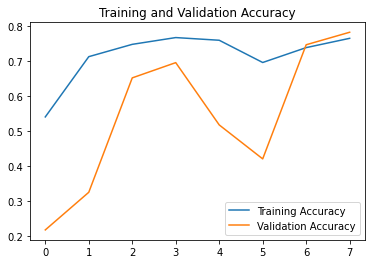

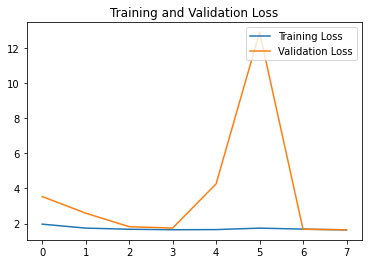

In [ ]:
acc = history_res152.history['accuracy']
val_acc = history_res152.history['val_accuracy']

loss = history_res152.history['loss']
val_loss = history_res152.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Reloading the model to make predictions
#model_res_pred = tf.keras.models.load_model('./saved_model_resnet.h5')
model_res_pred = tf.keras.models.load_model('./checkpoint_resnet.h5')

#Check the architecture
model_res_pred.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 16, 16, 2048)      58370944  
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 2048)      0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 12)                12300     
                                                      

In [ ]:
dataset_path = Path('/content/drive/MyDrive/plant-pathology-2021-fgvc8')

In [ ]:
test_folder_path = './test_images'

if not os.path.exists(test_folder_path):
    os.mkdir(test_folder_path) 

In [ ]:
test_ds_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/test_images'
test_dir_path = './test_images/all_classes'

if not os.path.exists(test_dir_path):
    shutil.copytree(test_ds_path, test_dir_path)

In [ ]:
_, _, files = next(os.walk(test_dir_path))
file_count = len(files)

print("Number of pictures: ", file_count)
print("Picture name: ", files)

Number of pictures:  14
Picture name:  ['85f8cb619c66b863.jpg', 'ad8770db05586b59.jpg', 'c7b03e718489f3ca.jpg', 'IMG_20211020_174743.jpg', 'IMG_20211020_174831.jpg', 'IMG_20211020_175040.jpg', 'IMG_20211020_175132.jpg', 'IMG_20211020_175253.jpg', 'IMG_20211020_175313.jpg', 'IMG_20211020_175324.jpg', 'IMG_20211020_175345.jpg', 'IMG_20211020_175417.jpg', 'IMG_20211020_175526.jpg', 'IMG_20211020_175840.jpg']


In [ ]:
test_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
test_folder_path = './test_images'

In [ ]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

In [ ]:
test_generator = test_image_generator.flow_from_directory(
                                        directory=test_folder_path,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        class_mode=None,
                                        shuffle=False
                                        )

Found 14 images belonging to 1 classes.


In [ ]:
pred_res = model_res_pred.predict_generator(test_generator, verbose=1)
print(pred_res)

<ipython-input-30-b52a3af38e71>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_res = model_res_pred.predict_generator(test_generator, verbose=1)


1/1 [==============================] - 17s 17s/step
[[1.06348582e-01 5.00211939e-02 4.44761105e-02 6.45597428e-02
  6.09636530e-02 4.63475510e-02 2.94173419e-01 6.17534481e-02
  4.25731577e-02 1.18769035e-01 6.41273633e-02 4.58867028e-02]
 [1.05603307e-01 8.04258659e-02 5.44059090e-02 9.94859189e-02
  7.74387196e-02 5.03567383e-02 1.93850219e-01 5.84323630e-02
  4.71304320e-02 1.03884161e-01 7.67007768e-02 5.22856377e-02]
 [1.00670263e-01 3.92076895e-02 3.40355895e-02 4.82833572e-02
  4.74973172e-02 3.85485217e-02 4.32590216e-01 5.10558225e-02
  3.11462432e-02 9.21008289e-02 5.15319593e-02 3.33321542e-02]
 [1.88034214e-02 1.62874663e-03 2.20488082e-03 1.89090241e-03
  2.91102566e-03 3.95042170e-03 9.45172250e-01 6.43723691e-03
  1.83476717e-03 9.15113930e-03 4.21173219e-03 1.80344982e-03]
 [1.74056026e-06 1.30887148e-10 2.03734163e-09 6.64942892e-11
  3.11792481e-09 4.56412934e-08 9.99997616e-01 2.24786334e-07
  2.78166867e-09 2.73374440e-07 8.21228863e-09 1.16983978e-09]
 [2.61256588e

In [ ]:
# making predictions on the testing image data
predicted_class_indices = np.argmax(pred_res, axis=1)
print("Predicted class indices:", predicted_class_indices)

labels_dict = ({'scab' : 0, 'healthy' : 1, 'frog_eye_leaf_spot' : 2, 'rust' : 3, 'complex' : 4, 'powdery_mildew' : 5, 'scab frog_eye_leaf_spot' : 6, 'scab frog_eye_leaf_spot complex' : 7, 'frog_eye_leaf_spot complex' : 8,'rust frog_eye_leaf_spot' : 9,'rust complex' : 10,'powdery_mildew complex' : 11})

labels = dict((v,k) for k,v in labels_dict.items())
predictions = [labels[k] for k in predicted_class_indices]
print("Predicted class:", predictions)

Predicted class indices: [6 6 6 6 6 6 6 6 6 3 6 6 9 3]
Predicted class: ['scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot', 'rust', 'scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot', 'rust frog_eye_leaf_spot', 'rust']


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_res_pred.predict_generator(valid_datagen, valid_datagen.samples // valid_datagen.batch_size + 5)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_datagen.classes, y_pred))

<ipython-input-32-011369040c7d>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_res_pred.predict_generator(valid_datagen, valid_datagen.samples // valid_datagen.batch_size + 5)


Confusion Matrix
[[ 25  46   0  77  27   0  38   0   0  94   0   0]
 [ 46 106   0 120  57   0  59   0   0 166   0   0]
 [  1   5   0   3   5   0   1   0   0   3   0   0]
 [ 59 135   0 193  83   0  99   0   0 245   0   0]
 [ 29  73   0  67  37   0  41   0   0  90   0   0]
 [  3   4   0   4   2   0   2   0   0   5   0   0]
 [ 33  70   0  95  41   0  47   0   0 112   1   0]
 [  0   2   0   3   1   0   1   0   0   5   0   0]
 [  1   6   0   7   1   0   1   0   0   8   0   0]
 [100 167   0 259 110   0 120   0   0 352   0   0]
 [  7  15   0  26  10   0  12   0   0  35   0   0]
 [  5   4   0   6   3   0   2   0   0   8   0   0]]


In [ ]:
#displaying the classification report including values for Precision, Recall, F1-score and Support for each disease class
target_names = list(train_datagen.class_indices.keys()) # Classes
print(classification_report(valid_datagen.classes, y_pred, target_names=target_names))

                                 precision    recall  f1-score   support

                        complex       0.08      0.08      0.08       307
             frog_eye_leaf_spot       0.17      0.19      0.18       554
     frog_eye_leaf_spot complex       0.00      0.00      0.00        18
                        healthy       0.22      0.24      0.23       814
                 powdery_mildew       0.10      0.11      0.10       337
         powdery_mildew complex       0.00      0.00      0.00        20
                           rust       0.11      0.12      0.11       399
                   rust complex       0.00      0.00      0.00        12
        rust frog_eye_leaf_spot       0.00      0.00      0.00        24
                           scab       0.31      0.32      0.32      1108
        scab frog_eye_leaf_spot       0.00      0.00      0.00       105
scab frog_eye_leaf_spot complex       0.00      0.00      0.00        28

                       accuracy                  

C:\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


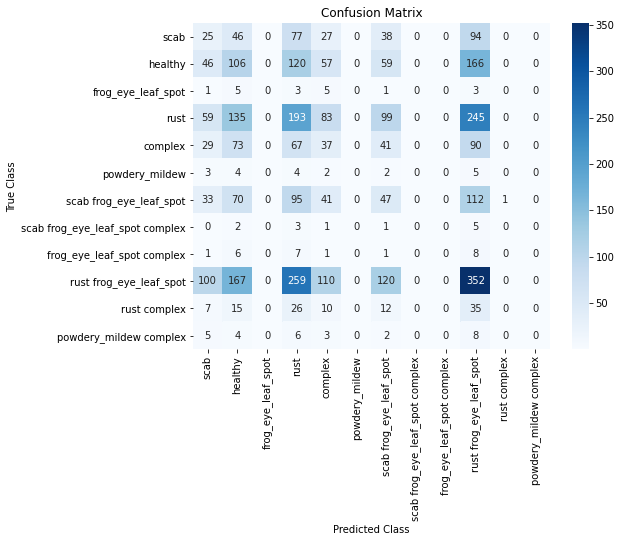

In [ ]:
#displaying the confusion matrix
import seaborn as sns

cm = confusion_matrix(valid_datagen.classes, y_pred)
labels = ['scab', 'healthy', 'frog_eye_leaf_spot', 'rust','complex', 'powdery_mildew','scab frog_eye_leaf_spot','scab frog_eye_leaf_spot complex','frog_eye_leaf_spot complex','rust frog_eye_leaf_spot','rust complex','powdery_mildew complex']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()